### 1 - Initial Overview and EDA

In [97]:
import os 
import pandas as pd
import numpy as np
from PIL import Image, ImageStat, ImageFile, Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from collections import Counter
import shutil
from collections import defaultdict


In [16]:
os.chdir("C:/Users/alexg/Ambiente de Trabalho/Mestrado Data Science NOVA IMS/2nd semester/DL/project")

In [ ]:
df = pd.read_csv("C:/Users/alexg/Ambiente de Trabalho/Mestrado Data Science NOVA IMS/2nd semester/DL/project/metadata.csv") 

In [5]:
df = pd.read_csv("C:/Users/alexg/Ambiente de Trabalho/Mestrado Data Science NOVA IMS/2nd semester/DL/project/metadata.csv") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11983 entries, 0 to 11982
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rare_species_id  11983 non-null  object
 1   eol_content_id   11983 non-null  int64 
 2   eol_page_id      11983 non-null  int64 
 3   kingdom          11983 non-null  object
 4   phylum           11983 non-null  object
 5   family           11983 non-null  object
 6   file_path        11983 non-null  object
dtypes: int64(2), object(5)
memory usage: 655.4+ KB


In [6]:
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

#### 1.1. Check if the metadata matches with the folders we have

In [25]:
# Check if the families in metadata match with 

print("Unique families in metadata:", df['family'].nunique())

# Optional cross-check:
df['phylum_family'] = df['phylum'] + "_" + df['family']
print("Unique phylum_family combos:", df['phylum_family'].nunique())


Unique families in metadata: 202
Unique phylum_family combos: 202


In [17]:
folder_names = os.listdir("rare_species")
print("Actual folders:", len(folder_names))

Actual folders: 202


#### 1.2. Plot the top 40 phylum_families in the dataset to look for possible target imbalance

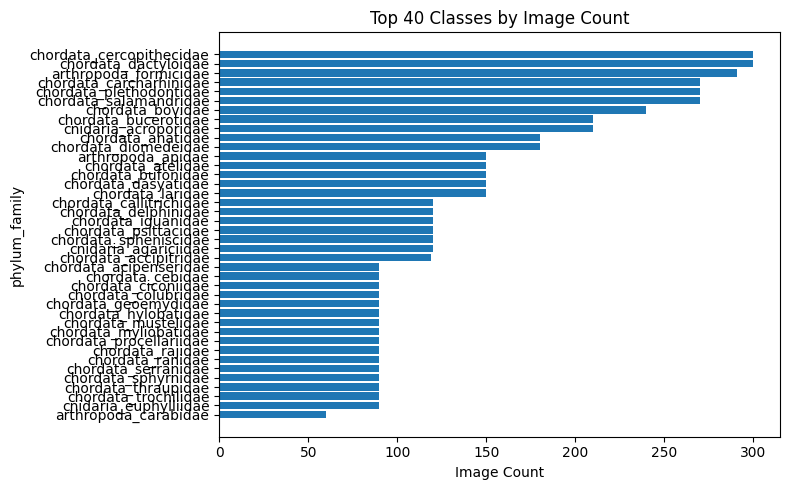

In [37]:
dataset_dir = "rare_species"


folder_counts = {
    folder: len(os.listdir(os.path.join(dataset_dir, folder)))
    for folder in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, folder))
}

# Sort by count
folder_counts = dict(sorted(folder_counts.items(), key=lambda x: x[1], reverse=True))


# Convert the dictionary to a DataFrame
counts_df = pd.DataFrame(folder_counts.items(), columns=["phylum_family", "count"])

top_n = 40
top_counts = counts_df.sort_values("count", ascending=False).head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(top_counts["phylum_family"], top_counts["count"])
plt.title(f"Top {top_n} Classes by Image Count")
plt.xlabel("Image Count")
plt.ylabel("phylum_family")
plt.gca().invert_yaxis()  # largest class on top
plt.tight_layout()
plt.show()


**Class Imbalance**

We can see from the image above that the img count for some phylum_familiy is really imbalanced. The top 2 phylum_family have 300 images while some other phylum_family have 6x less images. 

#### 1.3. Plot some samples for a given class

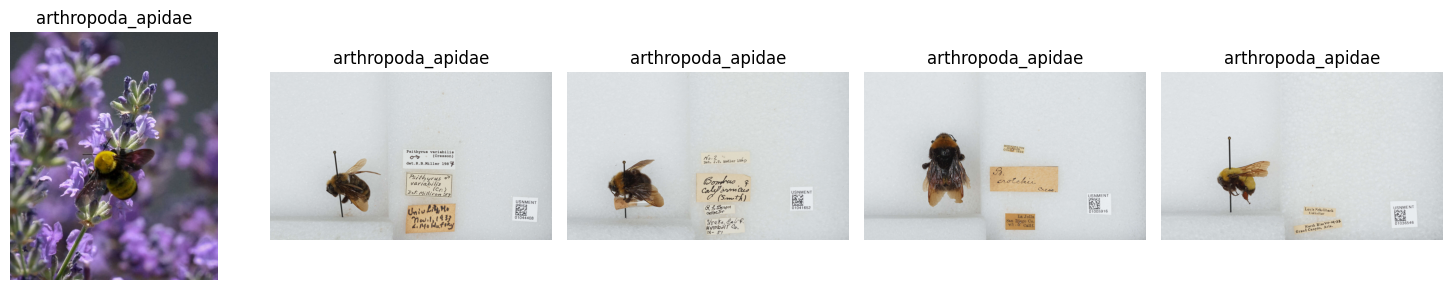

In [45]:
def show_samples(folder, base_path="rare_species", n=5):
    folder_path = os.path.join(base_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, min(n, len(images)))
    
    fig, axs = plt.subplots(1, len(selected), figsize=(15, 3))
    for ax, img_name in zip(axs, selected):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(folder)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example 
show_samples("arthropoda_apidae")



#### 1.4. Check if there is any corrupted image

In [60]:
corrupt_images = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except:
            corrupt_images.append(img_path)


c:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\2nd semester\DL\dl-venv\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


#### 1.5. Check image dimensions

In [49]:
dimensions = []

for folder in tqdm(os.listdir(dataset_dir)):
    folder_path = os.path.join(dataset_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                dimensions.append(img.size)  # (width, height)
        except:
            pass  # We'll count it as a corrupt image below

 98%|█████████▊| 197/202 [02:26<00:02,  1.68it/s]c:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\2nd semester\DL\dl-venv\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 202/202 [02:28<00:00,  1.36it/s]


In [50]:
dim_counts = Counter(dimensions)

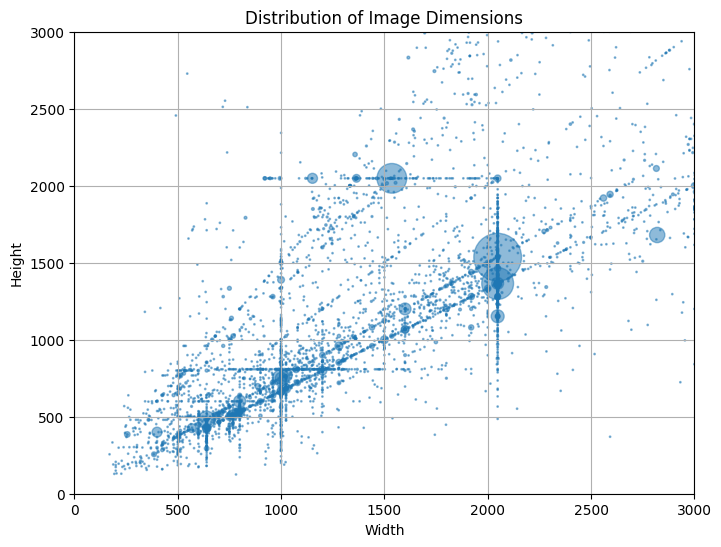

In [57]:
dim_counts.most_common(500)
# Convert to DataFrame for easier manipulation
dim_df = pd.DataFrame(dim_counts.items(), columns=["dimensions", "count"])
# Split the dimensions into separate columns
dim_df[["width", "height"]] = pd.DataFrame(dim_df["dimensions"].tolist(), index=dim_df.index)
# Drop the original dimensions column
dim_df.drop(columns=["dimensions"], inplace=True)
# Sort by count
dim_df.sort_values("count", ascending=False, inplace=True)
# Plotting the distribution of image dimensions
plt.figure(figsize=(8, 6))
plt.scatter(dim_df["width"], dim_df["height"], s=dim_df["count"], alpha=0.5)
plt.title("Distribution of Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.grid(True)
plt.show()

From the plot above we can see that our images vary a lot in **height** and **width**:

- **Clusters**: There are several distinct clusters of points, indicating common dimensions among the images. The largest clusters appear around the coordinates (1000, 1000) , (1500, 2000) and (2000,1500) 

- **Spread**: The points are spread across a range from (0, 0) to (3000, 3000), showing a variety of image sizes.

- **Trends**: There is a noticeable trend where many images have similar widths and heights, suggesting standardized dimensions in the dataset, probably due to common camera defaults (ex: 1024 x 768)


#### Which image dimensions can we apply in the pre processing?


#### Image Dimensions and Their Characteristics

| Dimensions | Description                      |
|------------|----------------------------------|
| 224x224    | Standard (VGG16, MobileNet), fast|
| 256x256    | Middle-ground             |
| 299x299    | Good detail, used in InceptionV3   |
| 384x384    | High detail , computationally expensive                   |



- Notes: Start with 224X224 img_dim shape for the VGG16 and MobileNet architecture, and then use the other resolutions and see if the performance improves

#### 1.6. Check Width/Height Ratio for all the images

In [70]:
ratios = [w / h for (w, h) in dimensions if h != 0]

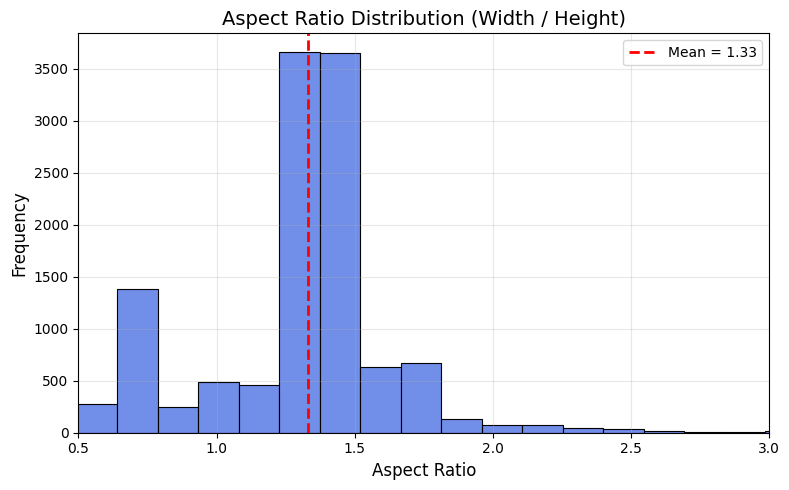

In [69]:
# aspect_ratios = your list of width / height ratios
mean_ar = np.mean(ratios)

plt.figure(figsize=(8, 5))
sns.histplot(ratios, bins=50, color='royalblue')
plt.axvline(mean_ar, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_ar:.2f}')

plt.title("Aspect Ratio Distribution (Width / Height)", fontsize=14)
plt.xlabel("Aspect Ratio", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0.5, 3)  # Set min and max for x-axis
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [107]:
avg_height = np.mean([h for (w, h) in dimensions if h != 0])
avg_width = np.mean([w for (w, h) in dimensions if w != 0])

print(f"Average Height: {avg_height:.2f}, Average Width: {avg_width:.2f}")

Average Height: 1512.26, Average Width: 1924.60


- Notes: 
    
    -- Most images have a width/height ratio near 1.5 (the red dashed line at ~1.5 shows the mean).

    -- There's a sharp peak, meaning a lot of images were probably taken in a standard camera aspect ratio, like 3:2

    -- A few images are unusually **Wide** (ratio > 4) , **Tall** (ratio< 0.5) -> These images get distorted heavily when resized to 224x224

#### 1.7. Check Image Brightness/Color Distribution

In [76]:
# Set your image root folder
base_dir = "rare_species"

# Get all full image paths
file_paths = []
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            full_path = os.path.join(folder_path, img_name)
            file_paths.append(full_path)

c:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\2nd semester\DL\dl-venv\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Text(0.5, 1.0, 'Image Brightness Distribution')

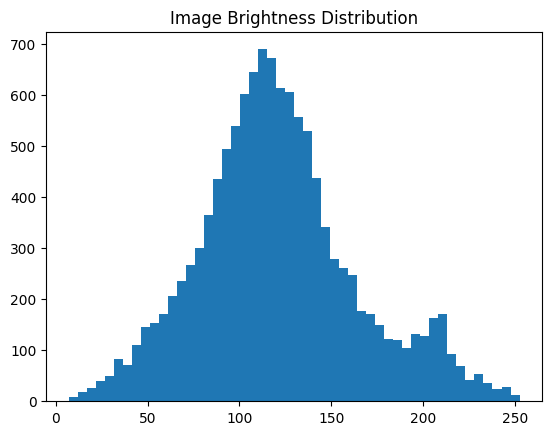

In [78]:
def get_brightness(img_path):
    img = Image.open(img_path).convert('L')  # grayscale
    stat = ImageStat.Stat(img)
    return stat.mean[0]

brightness_vals = [get_brightness(path) for path in file_paths]
plt.hist(brightness_vals, bins=50)
plt.title("Image Brightness Distribution")

X-axis: Brightness value — 0 = pitch black, 255 = pure white.

Very few overly dark (0–30) or overly bright (220+) images: That’s good. No major issues with exposure.



Nonetheless, we can:
- Keep them (they're rare)
- Augment or equalize them
- Drop them if needed

In [81]:
def check_mode(img_path):
    try:
        with Image.open(img_path) as img:
            return img.mode
    except:
        return None

modes = [check_mode(p) for p in file_paths]
print(pd.Series(modes).value_counts())


c:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\2nd semester\DL\dl-venv\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


RGB     11622
L         183
CMYK      178
Name: count, dtype: int64


Here's the corrected table in Markdown format:

| Mode  | Meaning                          | Count |
|-------|----------------------------------|-------|
| RGB   | Normal full-color images         | 11,622|
| L     | Grayscale (1 channel)            | 183   |
| CMYK  | Print-format (4 channels: Cyan, Magenta, Yellow, Black) | 178   |

DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels

- At least 1 very large image -> 10,000 x 10,000 pixels 


#### 1.8. Locate images that are not RGB and with very large size

In [ ]:
# Avoid crash on truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set limit if needed (for PIL warning threshold)
Image.MAX_IMAGE_PIXELS = None  # still shows warning, doesn't block loading

image_dir = "rare_species"

records = []

# Scan all images
for folder in tqdm(os.listdir(image_dir)):
    folder_path = os.path.join(image_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for fname in os.listdir(folder_path):
        img_path = os.path.join(folder_path, fname)
        try:
            with Image.open(img_path) as img:
                mode = img.mode
                size = img.size  # (width, height)
                pixels = size[0] * size[1]
                records.append({
                    "path": img_path,
                    "mode": mode,
                    "width": size[0],
                    "height": size[1],
                    "pixels": pixels
                })
        except Exception as e:
            print(f" Error reading {img_path}: {e}")


100%|██████████| 202/202 [00:03<00:00, 55.64it/s]


In [88]:
df_images = pd.DataFrame(records)

# Check non-RGB
non_rgb = df_images[df_images["mode"] != "RGB"]

non_rgb["mode"].value_counts()

mode
L       183
CMYK    178
Name: count, dtype: int64

In [92]:
non_rgb[["path", "mode"]].head(10)

path mode
484   rare_species\arthropoda_formicidae\28918248_62...    L
703   rare_species\arthropoda_nymphalidae\29698421_1...    L
716   rare_species\arthropoda_palinuridae\12306020_4...    L
717   rare_species\arthropoda_palinuridae\12306022_4...    L
1067  rare_species\chordata_accipitridae\9409302_104...    L
1075  rare_species\chordata_acipenseridae\12305607_4...    L
1077  rare_species\chordata_acipenseridae\12305609_4...    L
1078  rare_species\chordata_acipenseridae\12305610_4...    L
1099  rare_species\chordata_acipenseridae\24580741_4...    L
1100  rare_species\chordata_acipenseridae\24580742_4...    L

In [93]:
# print one path from non_rgb dataset
print(non_rgb.iloc[0]["path"])

rare_species\arthropoda_formicidae\28918248_620300_eol-full-size-copy.jpg


In [96]:
# Check for very large images (e.g. > 89 million pixels)
large_images = df_images[df_images["pixels"] > 89478485]
large_images[["path", "pixels", "width", "height"]].value_counts()

path                                                                      pixels     width  height
rare_species\mollusca_cardiidae\30003931_46473744_eol-full-size-copy.jpg  115600000  17000  6800      1
Name: count, dtype: int64

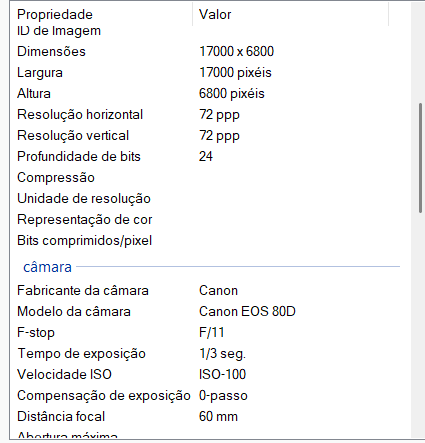

### 2 - Split the data set into train, val and test

In [98]:
# === CONFIG ===
source_dir = Path(r"C:\Users\alexg\Ambiente de Trabalho\Mestrado Data Science NOVA IMS\2nd semester\DL\project\rare_species")
target_dir = Path("dataset")
split_ratios = {"train": 0.7, "val": 0.15, "test": 0.15}
random.seed(42)

# Create split folders
for split in split_ratios:
    (target_dir / split).mkdir(parents=True, exist_ok=True)

# Iterate over classes
for class_folder in tqdm(list(source_dir.iterdir()), desc="Splitting dataset"):
    if not class_folder.is_dir():
        continue

    class_name = class_folder.name
    images = list(class_folder.glob("*.*"))  # assumes all are images
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * split_ratios["train"])
    n_val = int(n_total * split_ratios["val"])

    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    # Copy files into corresponding split folder
    for split_name, split_images in splits.items():
        split_class_dir = target_dir / split_name / class_name
        split_class_dir.mkdir(parents=True, exist_ok=True)
        for img_path in split_images:
            shutil.copy2(img_path, split_class_dir / img_path.name)

Splitting dataset: 100%|██████████| 202/202 [00:58<00:00,  3.47it/s]


In [99]:
from src.utils import load_ds

In [100]:
train_ds = load_ds(Path("dataset/train"))
val_ds   = load_ds(Path("dataset/val"))
test_ds  = load_ds(Path("dataset/test"))

Found 8367 files belonging to 202 classes.
Found 1723 files belonging to 202 classes.
Found 1893 files belonging to 202 classes.


In [ ]:
# # Try 224x224
# train_ds, val_ds, test_ds, class_names = prepare_datasets(
#     base_path="dataset",
#     image_size=(224, 224),
#     batch_size=32
# )

# # Try 299x299 later with InceptionNet
# train_ds, val_ds, test_ds, class_names = prepare_datasets(
#     base_path="dataset",
#     image_size=(299, 299),
#     batch_size=32
# )